In [54]:
import numpy as np
import os
from scipy.io.wavfile import read, write
import librosa as lrs
import librosa.display as lrsdis
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn import metrics

In [55]:

Fs, tempaudio = read(".\\trimmed_signals\\HuanLuyen-16k\\42FQT\\a.wav") 
char = ["a", "e", "i", "o", "u"]
# Tham số

NFFT = 2048    # độ dài vector FFT

frame_size = (int)(Fs * 0.005)  # Kích thước một frame
hop_size = (int)(0.005 * Fs)  # Kích thước một bước nhảy
training_path = ".\\trimmed_signals\\HuanLuyen-16k"  # đường dẫn đến file training
testing_path = ".\\trimmed_signals\\KiemThu-16k"

In [56]:
# Cắt audio bỏ đi 1/3 đoạn đầu, 1/3 đoạn sau, lấy đoạn giữa
def TrimPart(audio):

    length = len(audio)

    expect_len = length // 3

    start_id = expect_len // 3

    audio = audio[start_id : start_id + expect_len]
    return audio

In [57]:
def ReadFileByName(inputPath, r):
    audios = []

    # trả về danh sách các bản ghi âm đã cắt của ký tự char[r]
    for dirs in sorted(os.listdir(inputPath)):
        sub_path = os.path.join(inputPath, dirs)
        for files in sorted(os.listdir(sub_path)):
            if files[0] != char[r]:
                continue
            audio_path = os.path.join(sub_path, files)
            # print(audio_file)
            audio, fs = lrs.load(audio_path)
            audio = audio / abs(max(audio))
            # Tách audio và thêm vào danh sách audios
            audios.append(TrimPart(audio))
    return audios

In [58]:
def cal_nfft(audio):  # lấy giá trị vector FFT của một audio
    #
    frames = lrs.util.frame(audio, frame_length=frame_size, hop_length=hop_size)
    fft_frames = np.fft.fft(frames, NFFT, axis=0)  # hiện tại một cột là một vector
    res = np.abs(fft_frames)
    res = np.mean(res, axis=1)
    # print(len(res[0]))
    # frequencies = np.fft.fftfreq(NFFT, 1/Fs)
    # plt.plot(frequencies, res)
    # plt.title('Biểu đồ Phổ Tần Số')
    # plt.xlabel('Tần số (Hz)')
    # plt.ylabel('Biên độ')
    # plt.show()
    return res / abs(max(res))

In [59]:
def cal_feature(audios, c):
    # trích xuất đặc trưng từ danh sách các audio
    # lấy trung bình
    temp = []  # mảng hai chiều chứa thông tin các vector
    frequencies = np.fft.fftfreq(NFFT, 1 / Fs)
    for audio in audios:
        temp.append(cal_nfft(audio))
        # plt.plot(frequencies, temp[-1])
    temp = np.array(temp)
    # plt.plot(temp)
    if len(temp) != 21:
        print(len(temp))
    feature = np.mean(temp, axis=0)
    # plt.plot(feature)
    plt.legend(["a","e","i","o","u"])
    # plt.plot(frequencies, feature)
    # plt.title('Biểu đồ Phổ Tần Số '+char[c])
    # plt.xlabel('Tần số (Hz)')
    # plt.ylabel('Biên độ')
    # plt.show()
    return feature

(5, 2048)


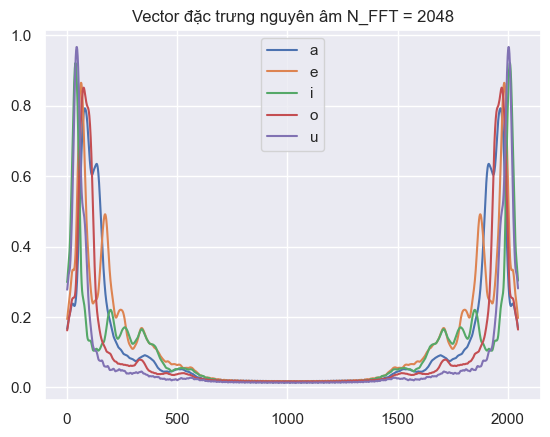

In [60]:
# Tất cả các bản ghi đều có tần số lấy mẫu là 16kHz
features = (
    []
)  # Kết quả , features[0] tương ứng vector FFT(ndarray) của chữ a, 1 của e,...
for i in range(0, 5):
    # if (i!=1): continue
    audios = ReadFileByName(training_path, i)
    features.append(cal_feature(audios, i))
# print(features)
features = np.array(features)
print(features.shape)
# plt.plot(np.array(features))
plt.title("Vector đặc trưng nguyên âm N_FFT = " + str(NFFT))
plt.plot(features[0])
plt.plot(features[1])
plt.plot(features[2])
plt.plot(features[3])
plt.plot(features[4])
plt.legend(["a", "e", "i", "o", "u"])
plt.savefig("B2Fig" + str(NFFT) + ".png")
cnt = 0

In [61]:
def check_feature(files_path, val):
    true_label = []
    predict = []
    cnt = 0
    for val in range(0, 5):
        audios = ReadFileByName(files_path, val)
        for audio in audios:
            decision = -1
            i = -1
            fft_audio = cal_nfft(audio)
            min_dif = np.linalg.norm(fft_audio - features[0])
            for feature in features:
                i += 1
                temp = np.linalg.norm(fft_audio - feature)
                if temp <= min_dif:
                    decision = i
                    min_dif = temp
            print("Testing " + char[val] + ", decision " + char[decision])
            true_label.append(char[val])
            predict.append(char[decision])
            if val == decision:
                cnt += 1
    return cnt, true_label, predict

    # return only the character which is most similar

Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision o
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision o
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision a
Testing a, decision o
Testing a, decision a
Testing a, decision a
Testing e, decision e
Testing e, decision o
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision o
Testing e, decision u
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing e, decision e
Testing i, decision i
Testing i, decision i
Testing i, decision i
Testing i,

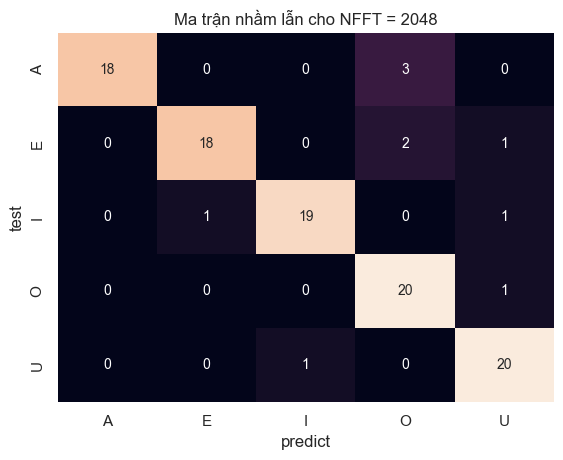

95/105


In [62]:
res = 0
res, test, predict = check_feature(testing_path, i)
cm = metrics.confusion_matrix(test, predict)
df_cm = pd.DataFrame(cm, index=[i for i in "AEIOU"], columns=[i for i in "AEIOU"])
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cbar=False)
plt.xlabel("predict")
plt.ylabel("test")
plt.title("Ma trận nhầm lẫn cho NFFT = " + str(NFFT))
plt.savefig("ConfusionMatrix" + str(NFFT) + ".jpg")
plt.show()
print(str(res) + "/105")